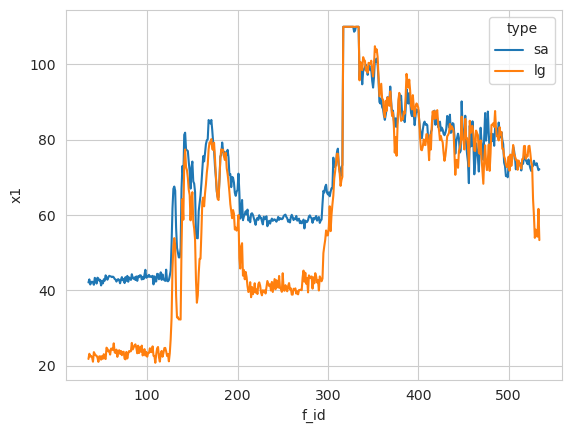

(0.0, 150.0)

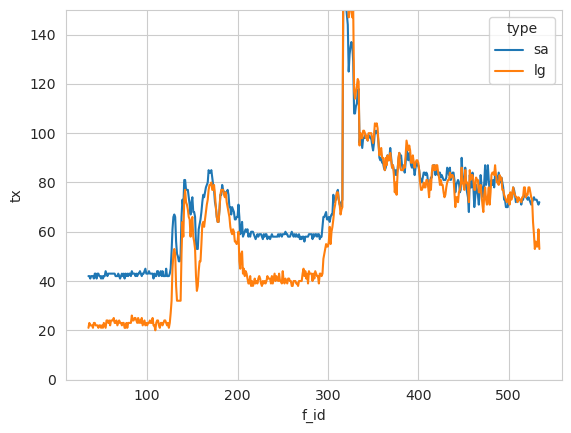

In [185]:
alinres = pd.read_csv("/media/fruitspec-lab/easystore/transloation_test/TEMP SSD_pre_S5/res.csv")
sns.lineplot(data = alinres, x = "f_id", y = "x1", hue = "type")
plt.show()
sns.lineplot(data = alinres, x = "f_id", y = "tx", hue = "type")
plt.ylim(0,150)

In [107]:
import os
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')
from MHS.F_model_training import *
from math import radians, cos, sin, asin, sqrt
from vision.misc.help_func import go_up_n_levels
os.chdir(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression, PoissonRegressor


from vision.tools.jupyter_notebooks import notebook_analysis_help_funcs
import importlib
importlib.reload(notebook_analysis_help_funcs)
from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *

In [108]:
master_folder = "/media/fruitspec-lab/cam175/customers_new/MOTCHA"
# master_folder = "/media/fruitspec-lab/Extreme Pro/MOTCHA"
row_lengths = run_on_folder(master_folder, return_time=True)
row_lengths

{'MOTCHA_BEERAMU0_R107_S1(220823)': (70.65422776056182, 13),
 'MOTCHA_BEERAMU0_R108_S1(220823)': (77.59997937232808, 13),
 'MOTCHA_BEERAMU0_R113_S1(220823)': (70.60296211402168, 13),
 'MOTCHA_BEERAMU0_R114_S1(220823)': (72.67555623636635, 13),
 'MOTCHA_MEIRAVHA_R101_S1(230723)': (0, 14),
 'MOTCHA_MICHAL22_R101_S1(240723)': (0, 15),
 'MOTCHA_MICHAL22_R102_S2(240723)': (0, 15),
 'MOTCHA_OR2009_R29_S1(210823)': (69.13429151431586, 12),
 'MOTCHA_OR2009_R32_S1(210823)': (155.83855035588874, 12),
 'MOTCHA_OR2009_R33_S1(210823)': (148.54547214996148, 12),
 'MOTCHA_OR2009_R34_S1(210823)': (157.01951037662204, 13),
 'MOTCHA_ORSCHIST_R44_S1(230813)': (97.91675574775833, 15),
 'MOTCHA_ORSCHIST_R45_S1(230813)': (99.95332879396923, 15),
 'MOTCHA_ORSCHIST_R5_S1(230813)': (104.27542937006963, 10),
 'MOTCHA_ORSCHIST_R6_S1(230813)': (106.01024973371895, 10),
 'MOTCHA_RAUSTENB_R2_S1(060723)': (0, 11),
 'MOTCHA_RAUSTENB_R3_S1(060723)': (0, 11)}

In [109]:
n_tracks = run_on_folder_tracks(master_folder, max_depth=5, full_cv=True)
n_tracks

{'MOTCHA_BEERAMU0_R107_S1(220823)': (5938, 3829, 2883, 2285, 1821, 22502, 0),
 'MOTCHA_BEERAMU0_R108_S1(220823)': (8522, 5039, 3710, 2860, 2275, 28724, 0),
 'MOTCHA_BEERAMU0_R113_S1(220823)': (5296, 3174, 2304, 1718, 1354, 17490, 0),
 'MOTCHA_BEERAMU0_R114_S1(220823)': (7943, 4920, 3769, 3027, 2466, 29935, 0),
 'MOTCHA_MEIRAVHA_R101_S1(230723)': (1718, 1163, 957, 830, 728, 9309, 0),
 'MOTCHA_MICHAL22_R101_S1(240723)': (1646, 1069, 867, 744, 631, 7833, 0),
 'MOTCHA_MICHAL22_R102_S2(240723)': (2954, 2061, 1649, 1354, 1159, 13856, 0),
 'MOTCHA_OR2009_R29_S1(210823)': (0, 0, 0, 0, 0, 0, 0.0),
 'MOTCHA_OR2009_R32_S1(210823)': (0, 0, 0, 0, 0, 0, 0.0),
 'MOTCHA_OR2009_R33_S1(210823)': (0, 0, 0, 0, 0, 0, 0.0),
 'MOTCHA_OR2009_R34_S1(210823)': (0, 0, 0, 0, 0, 0, 0.0),
 'MOTCHA_ORSCHIST_R44_S1(230813)': (5456, 3518, 2830, 2371, 2089, 25157, 0),
 'MOTCHA_ORSCHIST_R45_S1(230813)': (8127, 5053, 3908, 3221, 2736, 33168, 0),
 'MOTCHA_ORSCHIST_R5_S1(230813)': (4222, 2403, 1843, 1522, 1305, 16063, 0),


In [110]:
df_out = pd.DataFrame(n_tracks).T
df_out.columns = ["cv1", "cv2", "cv3", "cv4", "cv5", "n_dets", "ndropped"] #"depth_1", "depth_2", "depth_3"]
df_out.reset_index(names = "block", inplace = True)
row_len_df = pd.DataFrame(row_lengths).T
row_len_df.columns = ["row_len" , "time"]
df_out = df_out.merge(row_len_df.rename_axis('block'), on = "block")
for i in range(1,6):
    df_out[f"cv{i}_per_meter"] = df_out[f"cv{i}"]/df_out["row_len"]
df_out[f"dets_per_meter"] = df_out["n_dets"]/df_out["row_len"]
df_out = df_out[df_out["row_len"] > 60].reset_index(drop = True)
# df_out["time"] = df_out["time"].map({9: 'morning',
#                                      10: 'morning',
#            12: 'noon',
#            13: 'noon',
#            15: "sundown",
#            16: "sundown"})
# df_out.sort_values("block")

In [111]:
df_out["counter_row"] = df_out["block"].apply(lambda x: x.split("_")[2][1:]).apply(int)
df_out["block_name"] = df_out["block"].apply(lambda x: x.split("_")[1])

In [112]:
# df_out.to_csv("/home/fruitspec-lab/Downloads/MEHADRIN.csv")

In [113]:
real_row_path = "/media/fruitspec-lab/cam175/F_dfs/MEHADRINEXP_row_tags.csv"
df_real_row = pd.read_csv(real_row_path, encoding='ISO-8859-1')

In [114]:
df_out["row"] = df_out["block_name"] + "_R" + df_out["counter_row"].apply(str)

In [115]:
df_real_row["row"] = df_real_row["Block_name_row_tags"] +  "_R" + df_real_row["counter_row"].apply(str)

In [116]:
df_out = df_out.merge(df_real_row.set_index("row").drop("counter_row", axis = 1), on = "row")

In [117]:
df_out["sunside"] = df_out["sunside"].apply(lambda x: x.replace("back", "rear") if isinstance(x,str) else x)

In [118]:
# OR2009
# B sundown = towards sun
# B morning = sun is behind
# A morning = towards sun
# A sundown = sun is behind
grp_res = df_out.groupby(["real_row", "sunside", "block_name"]).median().drop(
    ["counter_row", "row_len", "ndropped"],axis = 1).reset_index()
grp_res["cv2/cv1"] = grp_res["cv2"]/grp_res["cv1"]
grp_res["cv3/cv1"] = grp_res["cv3"]/grp_res["cv1"]
grp_res

,real_row,sunside,block_name,cv1,cv2,cv3,cv4,cv5,n_dets,time,cv1_per_meter,cv2_per_meter,cv3_per_meter,cv4_per_meter,cv5_per_meter,dets_per_meter,cv2/cv1,cv3/cv1
0,1,noon,OR2009,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,2,noon,OR2009,0.0,0.0,0.0,0.0,0.0,0.0,12.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2,3,side_front,ORSCHIST,6566.0,3681.0,2761.0,2236.0,1869.0,23116.0,10.0,61.937407,34.723058,26.044651,21.092300,17.630371,218.054387,0.560615,0.420500
3,3,side_rear,ORSCHIST,4222.0,2403.0,1843.0,1522.0,1305.0,16063.0,10.0,40.488925,23.044738,17.674346,14.595960,12.514933,154.043959,0.569162,0.436523
4,4,side_front,ORSCHIST,5456.0,3518.0,2830.0,2371.0,2089.0,25157.0,15.0,55.720800,35.928478,28.902101,24.214446,21.334449,256.922319,0.644795,0.518695
5,4,side_rear,ORSCHIST,8127.0,5053.0,3908.0,3221.0,2736.0,33168.0,15.0,81.307947,50.553594,39.098248,32.225040,27.372775,331.834871,0.621755,0.480866
6,5,noon,BEERAMU0,7230.0,4434.0,3296.5,2572.5,2048.0,25613.0,13.0,96.931356,59.564543,44.306822,34.598139,27.545211,344.317663,0.613278,0.455947
7,6,noon,BEERAMU0,6619.5,4047.0,3036.5,2372.5,1910.0,23712.5,13.0,92.152493,56.326881,42.246910,32.992062,26.554647,329.811235,0.611375,0.458720


In [119]:
grp_res["block_row"] = grp_res["block_name"] + "_R" + grp_res["real_row"].apply(str)

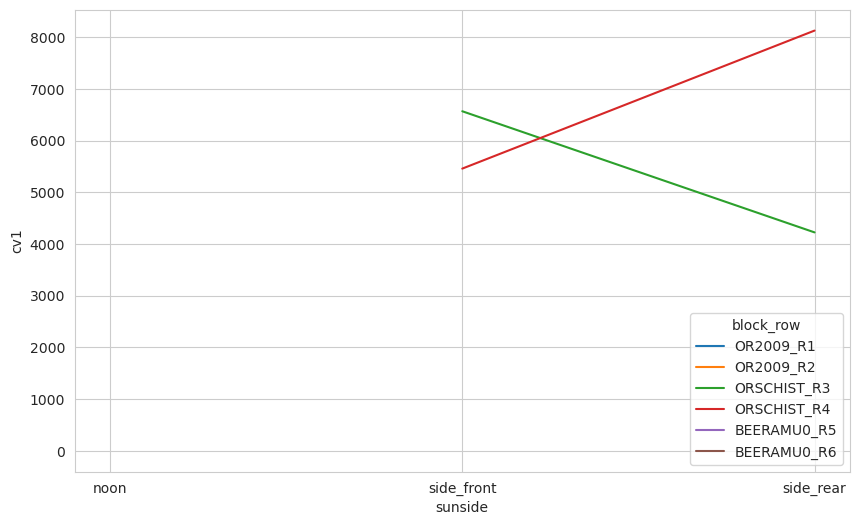

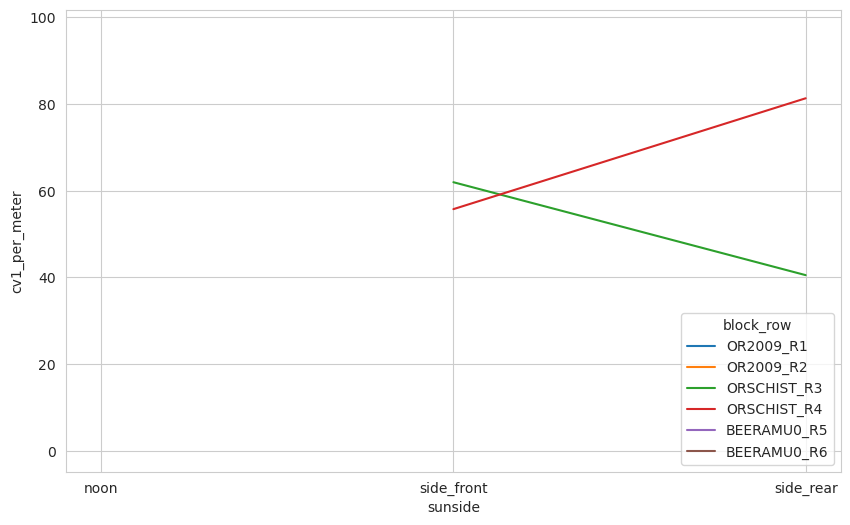

In [120]:
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res, x = "sunside", y= "cv1", hue = "block_row")
plt.show()
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res, x = "sunside", y= "cv1_per_meter", hue = "block_row")
plt.show()

# CV sunside analysis after slicing

In [121]:
or2009_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/OR2009/cv_features.csv"
BEERAMU0_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/BEERAMU0/cv_features.csv"
ORSHICHT_cv_features = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/ORSCHIST/cv_features.csv"
cv_features_paths = [or2009_cv_features, BEERAMU0_cv_features, ORSHICHT_cv_features]
cv_df = pd.concat([pd.read_csv(p) for p in cv_features_paths])

In [122]:
cv_df["row"] = cv_df["block_name"] + "_" + cv_df["name"].apply(lambda x: x.split("_")[0])
value_counts = cv_df['row'].value_counts()
valid_row = list(value_counts[value_counts==1].index)
valid_trees = (cv_df["name"][cv_df["name"].str.contains("T11")]).values
cv_df_valid = cv_df[np.isin(cv_df["row"], valid_row) | np.isin(cv_df["name"], valid_trees)]

In [123]:
cv_df_valid = cv_df_valid.merge(df_real_row.set_index("row").drop("counter_row", axis = 1), on = "row")
cv_df_valid["sunside"] = cv_df_valid["sunside"].apply(lambda x: x.replace("back", "rear"))


In [124]:
cv_df_valid["block_real_row"] = cv_df_valid["block_name"] + "_R" + cv_df_valid["real_row"].apply(str)

In [125]:
cv_df_valid[["cv1", "real_row", "sunside", "block_name", "row"]].sort_values(["real_row", "sunside"])

,cv1,real_row,sunside,block_name,row
8,5277,1,front,OR2009,OR2009_R54
10,4138,1,front,OR2009,OR2009_R7
1,3179,1,noon,OR2009,OR2009_R29
2,3806,1,noon,OR2009,OR2009_R32
7,2586,1,rear,OR2009,OR2009_R53
9,3515,1,rear,OR2009,OR2009_R6
6,4667,2,front,OR2009,OR2009_R47
11,4485,2,front,OR2009,OR2009_R9
3,3145,2,noon,OR2009,OR2009_R33
4,3159,2,noon,OR2009,OR2009_R34


In [126]:
grp_res_cv = cv_df_valid.groupby(["real_row", "sunside", "block_name"]).median().reset_index()
grp_res_cv["block_real_row"] = grp_res_cv["block_name"] + "_R" + grp_res_cv["real_row"].apply(str)
grp_res_cv = grp_res_cv.sort_values(["block_name","sunside"])

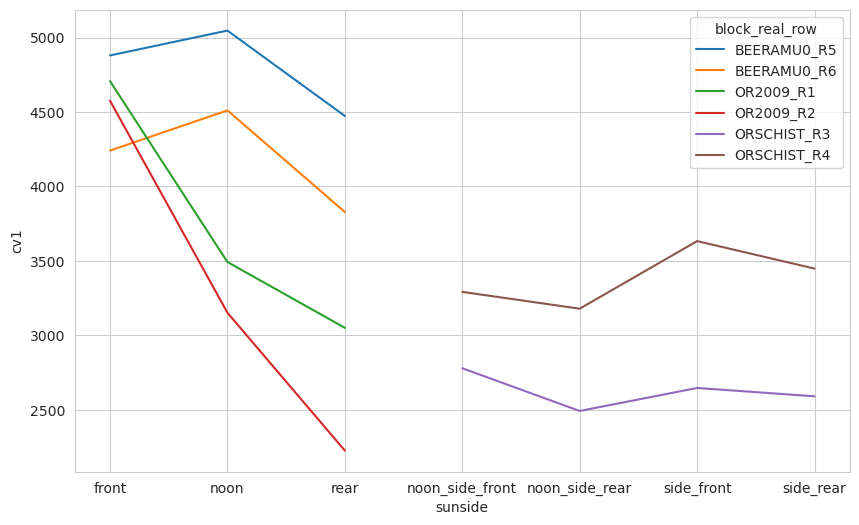

In [127]:
plt.figure(figsize = (10,6))
sns.lineplot(data = grp_res_cv, x = "sunside", y= "cv1", hue = "block_real_row")
plt.show()

In [128]:
dfs_list = []
for real_row in grp_res_cv["real_row"].unique():
    real_row_subdf = grp_res_cv[grp_res_cv["real_row"] == real_row]
    if not "side" in real_row_subdf["sunside"].iloc[0]:
        real_row_subdf = grp_res_cv[grp_res_cv["real_row"] == real_row]
        front_cv = real_row_subdf[real_row_subdf["sunside"] == "front"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]                                                                            
        noon_cv = real_row_subdf[real_row_subdf["sunside"] == "noon"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]
        rear_cv = real_row_subdf[real_row_subdf["sunside"] == "rear"].reset_index(drop=True)[[f"cv{i}" for i in range(1,6)]]
        ratios_df = pd.concat([front_cv/noon_cv, rear_cv/noon_cv])
        ratios_df["real_row"] = real_row
        ratios_df["sunside"] = ["front", "rear"]
        dfs_list.append(ratios_df)
factor_ratios = pd.concat(dfs_list)


In [129]:
1/factor_ratios[np.isin(factor_ratios["real_row"], [1,2])].groupby("sunside").mean()

,cv1,cv2,cv3,cv4,cv5,real_row
sunside,,,,,,
front,0.714371,0.844879,1.051221,1.297317,1.594068,0.666667
rear,1.266094,1.247948,1.237974,1.260584,1.276936,0.666667


In [130]:
factor_ratios.groupby("sunside").median()

,cv1,cv2,cv3,cv4,cv5,real_row
sunside,,,,,,
front,1.157400,0.985457,0.808822,0.721203,0.628604,3.5
rear,0.861073,0.773563,0.720983,0.701788,0.691846,3.5


# F_modeling

### Load data

In [131]:
features_df = cv_df.copy()
f_df = pd.read_csv("/media/fruitspec-lab/cam175/F_dfs/MEHADRINEXP_F.csv")


In [132]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]

In [133]:
features_df["real_row"] = features_df["row"].map(dict(zip(df_real_row["row"],
                                                              df_real_row["Block_name_row_tags"] +
                                                          "_R" + df_real_row["real_row"].apply(str))))
features_df["sunside"] = features_df["row"].map(dict(zip(df_real_row["row"], df_real_row["sunside"])))
features_df["side"] = features_df["row"].map(dict(zip(df_real_row["row"], df_real_row["side"])))

In [134]:
# merge F on name
df_f_org = features_df
df_f_org["F"] = features_df["full_name"].map(dict(zip(f_df["full_name"], f_df["F"])))

In [135]:
rows_F = df_f_org.groupby("real_row")["F"].sum()/2
cv_df_valid["F"] = cv_df_valid["block_real_row"].map(dict(rows_F))
cv_df_valid["factor"] = cv_df_valid["F"]/cv_df_valid["cv1"]

In [136]:
df_f_org = df_f_org[~df_f_org["F"].isna()].reset_index(drop = True)

In [137]:
df_f_org[[f"cv{i}" for i in range(1,6)] + 
         ["F", "name", "block_name"]].to_csv("/media/fruitspec-lab/cam175/MEHADRINEXP/MEHADRINEXP_cv_and_F.csv")


In [138]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    df_f_org[cv_F_col] = df_f_org[cv_col]/df_f_org["F"]

In [139]:
# df_f_org.to_csv(f"{df_f_path.split('.')[0]}_cvf.csv")

### Short EDA

In [140]:
df_f_org[df_f_org["side"] == "B"][cv_F_cols].mean().round(2)

cv1/F    0.56
cv2/F    0.32
cv3/F    0.23
cv4/F    0.18
cv5/F    0.15
dtype: float64

In [141]:
df_f_org.groupby(["block_name"])[cv_F_cols].mean().round(2)

,cv1/F,cv2/F,cv3/F,cv4/F,cv5/F
block_name,,,,,
BEERAMU0,0.69,0.37,0.26,0.19,0.15
OR2009,0.40,0.25,0.19,0.15,0.12
ORSCHIST,0.57,0.31,0.23,0.18,0.15


In [142]:
df_f = df_f_org.copy()

### CV-F graphs

<Figure size 1000x600 with 0 Axes>

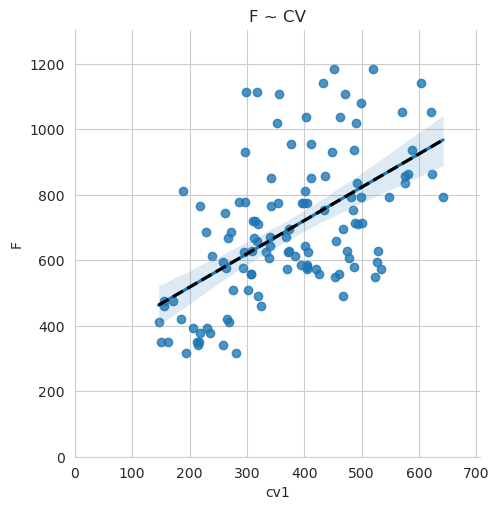

In [143]:
plot_F_cv(df_f_org, "1", title = "F ~ CV", add_xy_line=False)

<Figure size 1000x600 with 0 Axes>

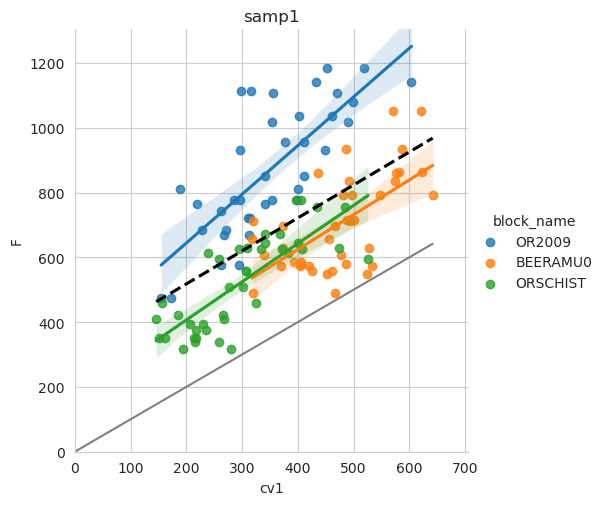

<Figure size 1000x600 with 0 Axes>

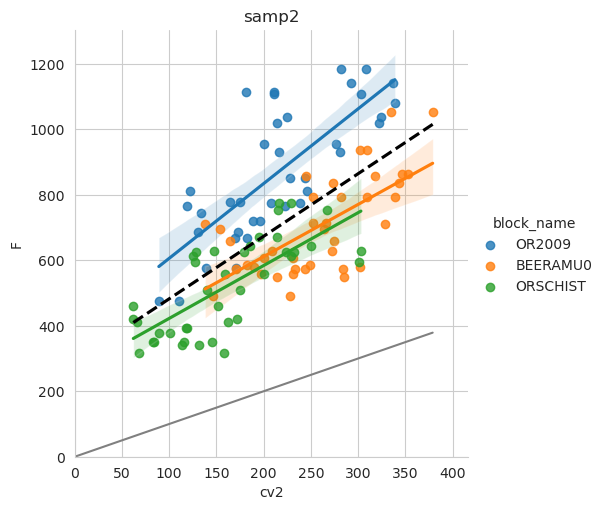

<Figure size 1000x600 with 0 Axes>

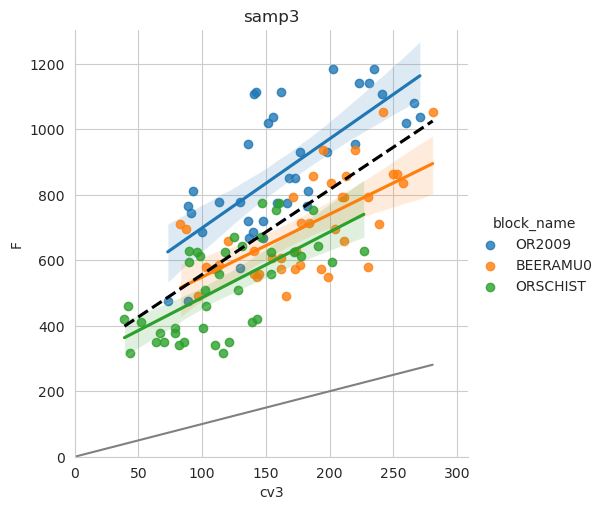

<Figure size 1000x600 with 0 Axes>

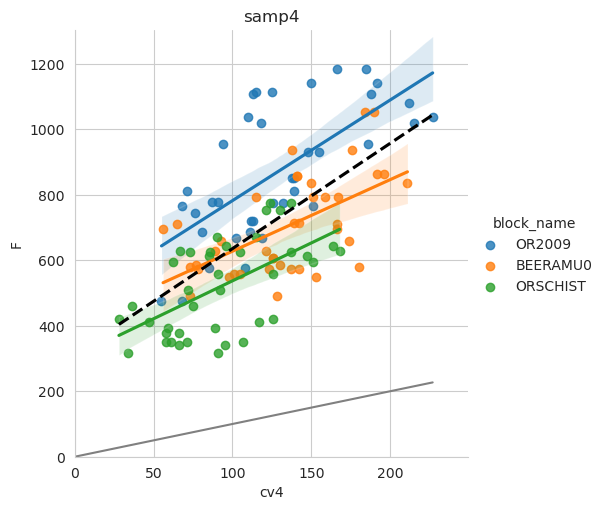

<Figure size 1000x600 with 0 Axes>

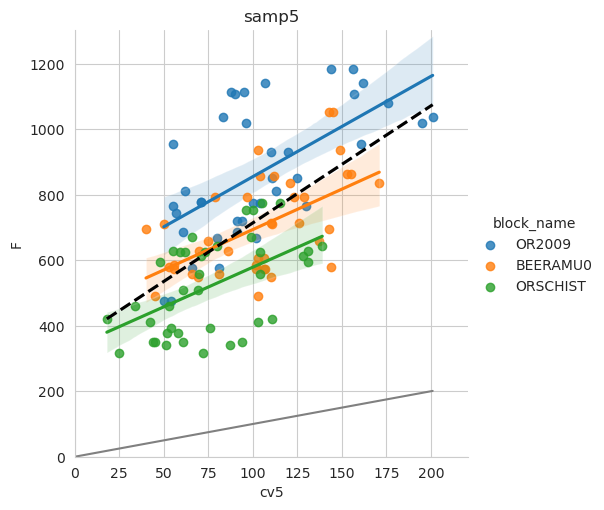

In [144]:
for i in range(1,6):
    plot_F_cv(df_f,i,"block_name", f"samp{i}")

<Figure size 1000x600 with 0 Axes>

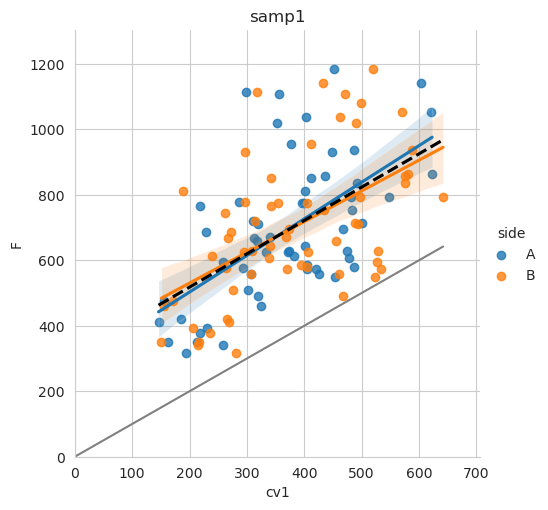

<Figure size 1000x600 with 0 Axes>

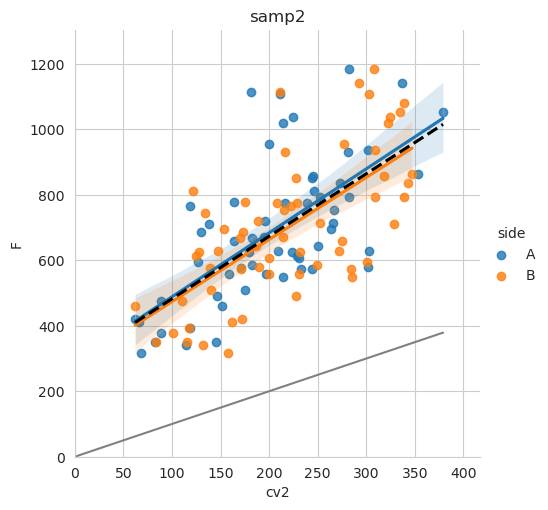

<Figure size 1000x600 with 0 Axes>

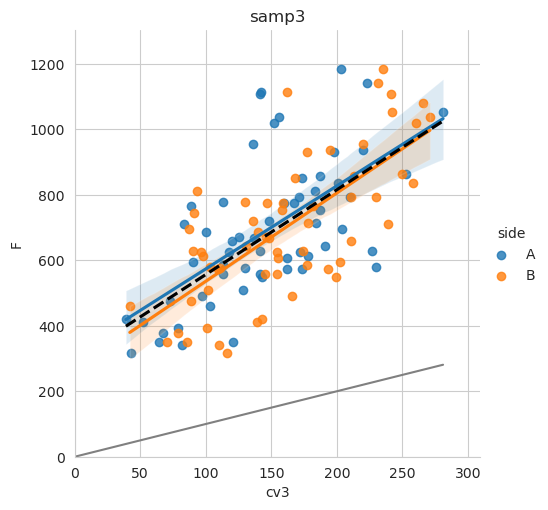

<Figure size 1000x600 with 0 Axes>

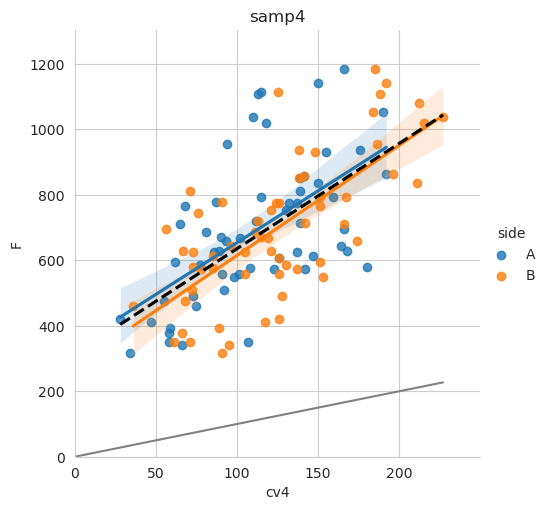

<Figure size 1000x600 with 0 Axes>

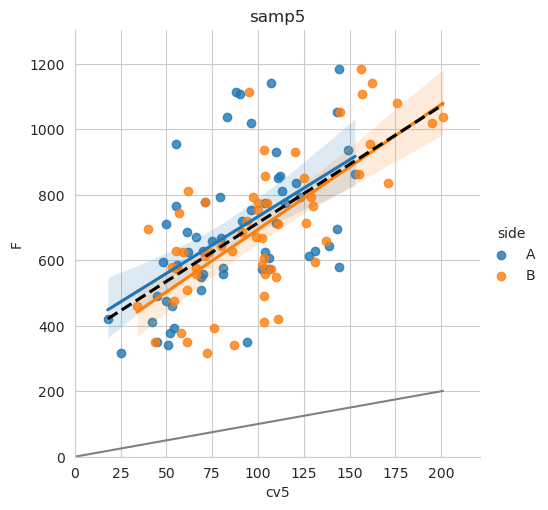

In [145]:
for i in range(1,6):
    plot_F_cv(df_f,i,"side", f"samp{i}")

### Modeling

In [146]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

## Per row factor

In [149]:
fit_intercept = False
cv_col = ["cv1"]
df = df_f.reset_index(drop=True).copy()
for block in df["block_name"].unique():
    block_df = df[df["block_name"] == block]
    for row in block_df["row"].unique():
        row_df = block_df[block_df["row"]==row]
        X = row_df[cv_col].reset_index(drop=True)
        y = row_df["F"].reset_index(drop=True)
        model = LinearRegression(fit_intercept=fit_intercept)
        print(row)
        model.fit(X, y)
        print(model.coef_)

OR2009_R29
[2.21671059]
OR2009_R32
[2.31773765]
OR2009_R33
[2.60089392]
OR2009_R34
[2.59047138]
BEERAMU0_R107
[1.37572295]
BEERAMU0_R108
[1.53533771]
BEERAMU0_R113
[1.47469337]
BEERAMU0_R114
[1.54104212]
ORSCHIST_R44
[1.71879889]
ORSCHIST_R45
[1.76268658]
ORSCHIST_R5
[1.67951793]
ORSCHIST_R6
[1.58233321]


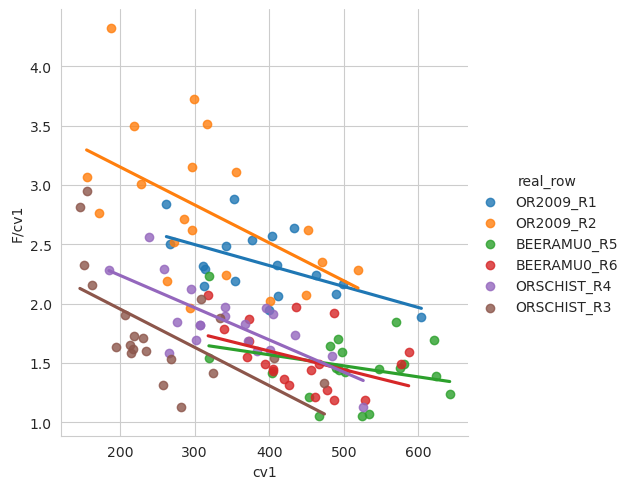

In [171]:
df_f["F/cv1"] = df_f["F"]/df_f["cv1"]
df_f["blcok_side"] = df_f["block_name"] + "_"+ df_f["side"]
sns.lmplot(data=df_f, x="cv1", y="F/cv1", hue="real_row", ci=None)

In [106]:
df_f["row"] = df_f["real_row"]

df = df_f.reset_index(drop = True).copy()
X = df[["cv1"]]
y = df["F"]
model = LinearRegression(fit_intercept = False)
print(cross_validate_with_mean(model, X, y, groups=df["row"]))
print(cross_validate_with_mean(model, X, y, groups=df["block_name"]))
model.fit(X,y)
print(model.intercept_, model.coef_)

true: 12340.0,    pred: 12310.564549614473. (0.24 %) (ORSCHIST_R4)
true: 8508.0,    pred: 8966.7741603173. (5.39 %) (ORSCHIST_R3)
true: 16858.0,    pred: 10484.842453650675. (37.80 %) (OR2009_R2)
true: 13360.0,    pred: 16321.346959747567. (22.17 %) (BEERAMU0_R6)
true: 14748.0,    pred: 19436.17555980349. (31.79 %) (BEERAMU0_R5)
true: 16158.0,    pred: 11835.218487325235. (26.75 %) (OR2009_R1)
0.2646357584229297 0.08722608849409796
(0.20690544677772585, 0.1358505531975165)
true: 20848.0,    pred: 21431.187493590925. (2.80 %) (ORSCHIST)
true: 28108.0,    pred: 39745.25866366755. (41.40 %) (BEERAMU0)
true: 33016.0,    pred: 20453.33718301107. (38.05 %) (OR2009)
0.32857492002816463 0.12079930361936754
(0.2741650070844757, 0.17462076139567853)
0.0 [1.7810211]


In [ ]:
run_LROCV_by_block(df_f, "cv1")

In [ ]:
run_LROCV_by_block(df_f, "cv1")

In [ ]:
run_LROCV_by_block(df_f, "cv1", fit_intercept=True)

## More features

In [158]:
def collect_row_features(starting_directory, file_name = "row_features.csv"):
    dfs_list = []
    for root, _, files in os.walk(starting_directory):
        for file in files:
            if file == file_name:
                file_path = os.path.join(root, file)
                df_list.append(pd.read_csv(file_path))
    return dfs_list

In [159]:
df_list = []

In [160]:
starting_directory = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/BEERAMU0"
df_list += collect_row_features(starting_directory, file_name = "row_features.csv")
starting_directory = "/media/fruitspec-lab/cam175/customers_new/MOTCHA/ORSCHIST"
df_list += collect_row_features(starting_directory, file_name = "row_features.csv")

In [169]:
features_df = pd.concat(df_list)
features_df = features_df[~features_df["name"].str.endswith("T11")]
features_df["row"] = features_df["name"].apply(lambda x: x.split("_")[0])
features_df.groupby(["block_name", "row"])[["surface_area", "percent_seen", "foliage_fullness"]].mean().reset_index().round(2)

,block_name,row,surface_area,percent_seen,foliage_fullness
0,BEERAMU0,R107,5.88,0.79,0.89
1,BEERAMU0,R108,6.25,0.85,0.92
2,BEERAMU0,R113,5.80,0.73,0.89
3,BEERAMU0,R114,5.01,0.83,0.92
4,ORSCHIST,R44,5.11,0.85,0.88
5,ORSCHIST,R45,4.76,0.87,0.93
6,ORSCHIST,R5,5.94,0.86,0.86
7,ORSCHIST,R6,5.55,0.81,0.90


# 2 sided test

In [ ]:
# f_df_serinal["base_tree_name"] = base_tree_name
# f_df_serinal["tree_new_name"] = tree_new_name
# features_df[features_df["customer"].isin(["FOWLER", "MOTCHA"])]["full_name"]
# features_df.loc[:, "name"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
#                                                                    f_df_serinal["tree_new_name"])))
# features_df["side"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
#                                                                    f_df_serinal["side"])))

In [ ]:
features_df["full_name"] = features_df["block_name"] + "_" + features_df["name"]
f_df["full_name"] = f_df["block_name"] + "_" + f_df["new_tree_name"]
f_df_serinal = f_df[~f_df["tree_serial"].isna()]
f_df_serinal["side"].replace({"A":1, "B":2}, inplace=True)

f_df_serinal["real_row"] = f_df_serinal["full_name"].map(dict(zip(features_df["full_name"],
                                      features_df["real_row"])))
f_df_serinal["real_row"].fillna("OR2009_R1", inplace = True)

base_tree_name = f_df_serinal["real_row"] + "_T" + f_df_serinal["tree_serial"].astype(int).astype(str)
tree_new_name = base_tree_name + "_S" + f_df_serinal["side"].replace({"A":1, "B":2}).astype(int).astype(str)
tree_new_name = tree_new_name.apply(lambda x: f'{x.split("_")[1]}_{x.split("_")[3]}_{x.split("_")[2]}')
f_df_serinal["base_tree_name"] = base_tree_name
f_df_serinal["tree_new_name"] = tree_new_name
features_df[features_df["customer"].isin(["FOWLER", "MOTCHA"])]["full_name"]
features_df.loc[:, "name"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
                                                                   f_df_serinal["tree_new_name"])))
features_df["side"] = features_df["full_name"].map(dict(zip(f_df_serinal["full_name"],
                                                                   f_df_serinal["side"])))

In [ ]:
df_f = features_df[~features_df["F"].isna()].copy().reset_index(drop=True)
cv_cols = ["cv1", "cv2", "cv3", "cv4" ,"cv5"]

df_f["base_tree_name"] = df_f["block_name"] + "_"  + df_f["name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[-1])
counts = df_f["base_tree_name"].value_counts()>1
df_f = df_f[df_f["base_tree_name"].map(dict(zip(counts.index, counts.values)))]


In [ ]:
grouped_trees = df_f.groupby("base_tree_name")[cv_cols + ["F"]].mean()
grouped_trees[cv_cols] = grouped_trees[cv_cols]*2
grouped_trees["base_tree_name"] = list(grouped_trees.index)
grouped_trees["block_name"] = grouped_trees["base_tree_name"].apply(lambda x: x.split("_")[0])

In [ ]:
cv_cols = [f"cv{i}" for i in range(1,6)]
cv_F_cols = [f"{col}/F" for col in cv_cols]
for cv_col, cv_F_col in zip(cv_cols, cv_F_cols):
    grouped_trees[cv_F_col] = grouped_trees[cv_col]/grouped_trees["F"]
grouped_trees.groupby("block_name")[cv_F_cols].mean().round(2)

In [ ]:
grouped_trees["real_row"] = grouped_trees["base_tree_name"].apply(lambda x: x.split("_")[0] + "_" + x.split("_")[1])

In [ ]:
operational_rows = {"1_1": "R1", 
                   "1_2": "R2", 
                   "2_1": "R2", 
                   "2_2": "R1", 
                   "3_1": "R3", 
                   "3_2": "R4", 
                   "4_1": "R4", 
                   "4_2": "R3", 
                   "5_1": "R5", 
                   "5_2": "R6", 
                   "6_1": "R6", 
                   "6_2": "R5"}
df_f["operational_rows"] = df_f["real_row"].apply(lambda x: x.split("_")[1][1:]) + "_" + df_f["side"].apply(int).apply(str)
df_f["operational_rows"] = df_f["operational_rows"].map(operational_rows)


In [ ]:
results_list = []
include_fruits = False
include_interaction=False
for cv in range(1,6):
    # 2 sided
    df = grouped_trees.reset_index(drop=True).copy()
    gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
    lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
    res = {"model": "2_sided", "cv": cv,
           "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
           "tree_mape": tree_res, "tree_std": tree_std}
    results_list.append(res)

    df = df_f.reset_index(drop=True)
    gr_res, ge_std, tree_res, tree_std, oper_preds = get_model_res(df, cv, include_fruits, include_interaction)
    lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "operational_rows")
    df["oper_preds"] = oper_preds
    grpd_res = df.groupby(["block_name","operational_rows"])["F", "oper_preds"].sum().reset_index()
    gr_res = np.mean((abs(grpd_res["F"]-grpd_res["oper_preds"])/grpd_res["F"]))
    ge_std = np.std(abs(grpd_res["F"]-grpd_res["oper_preds"])/grpd_res["F"])
    res = {"model": "opertional", "cv": cv,
           "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
           "tree_mape": tree_res, "tree_std": tree_std}
    results_list.append(res)
    # 1 side 2 trees
#             df = df_f.reset_index(drop=True).copy()
#             gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#             lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#             res = {"model": "1_sided", "cv": cv,
#                    "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std, "tree_mape": tree_res, "tree_std": tree_std,
#                   "include_fruits": include_fruits, "include_interaction": include_interaction}
#             results_list.append(res)

    #side A only
#     df = df_f[df_f["side"] == 1].reset_index(drop=True).copy()
#     gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#     lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#     res = {"model": "A", "cv": cv,
#            "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
#            "tree_mape": tree_res, "tree_std": tree_std}
#     results_list.append(res)

    #side B only
#     df = df_f[df_f["side"] == 2].reset_index(drop=True).copy()
#     gr_res, ge_std, tree_res, tree_std, preds = get_model_res(df, cv, include_fruits, include_interaction)
#     lro_res, lro_std, _, _, _ = get_model_res(df, cv, include_fruits, include_interaction, "real_row")
#     res = {"model": "B", "cv": cv,
#            "LBOCV": gr_res, "LBOCV_std": ge_std, "LROCV": lro_res, "LROCV_std": lro_std,
#            "tree_mape": tree_res, "tree_std": tree_std}
#     results_list.append(res)
                        
summary_res = pd.DataFrame(results_list)   
summary_res.round(3)